In [1]:
#Cell 0
import os
os.environ["USE_TF"] = "0"
import warnings
import re
import string
import random
import math
import joblib
import inspect
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import nltk
import textstat
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from datasketch import MinHash, MinHashLSH
from wordcloud import WordCloud

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    cohen_kappa_score,
    matthews_corrcoef,
    average_precision_score,
    balanced_accuracy_score,
)

from datasets import Dataset, DatasetDict, load_from_disk
import evaluate

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    DistilBertTokenizerFast,
    DistilBertForMaskedLM,
    DataCollatorForLanguageModeling,
    pipeline
)

from peft import LoraConfig, get_peft_model
from pathlib import Path
from torch.nn import CrossEntropyLoss

warnings.filterwarnings("ignore", category=FutureWarning)
nltk.download("wordnet", quiet=True)
sns.set_theme(style="whitegrid", palette="muted")

print("\nLibraries Loaded Successfully!")


Libraries Loaded Successfully!


In [ ]:
# Cell 1: Define your dataset directories
ISOT_DIR = r"X:\Projects\Personal\Fake News Detector\datasets\ISOT Fake News Dataset"     
LIAR_DIR = r"X:\Projects\Personal\Fake News Detector\datasets\LIAR A Benchmark Dataset for Fake News Detection"
FNC_DIR  = r"X:\Projects\Personal\Fake News Detector\datasets\Fake News Challenge Stage 1 (FNC-1)"

CACHE_PARQUET  = r"X:\Projects\Personal\Fake News Detector\cache\aug2_backtranslations.parquet"
TOKENIZED_CACHE = Path(r"X:\Projects\Personal\Fake News Detector\cache\processed_mlm_ds")
CLS_CACHE = Path(r"X:\Projects\Personal\Fake News Detector\cache\processed_cls_ds")


MLM_OUTPUT_DIR = r"X:\Projects\Personal\Fake News Detector\outputs\mlm output"
CHECKPOINT_DIR = r"X:\Projects\Personal\Fake News Detector\outputs\checkpoints"
TOKEN_DIR = r"X:\Projects\Personal\Fake News Detector\cache\tokenized_dataset"
print("Directories Defined Succesfully!")

Directories Defined Succesfully!


Total examples loaded: 107661
Found 716 empty-clean examples.
After dropping empties, dataset size: 106945
Before deduplication: 106945
After deduplication:  93784


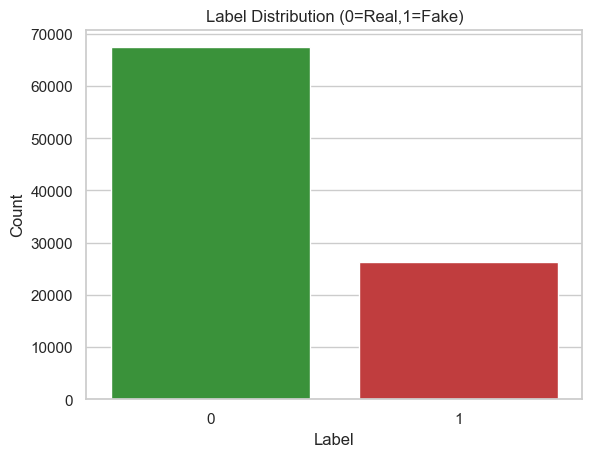

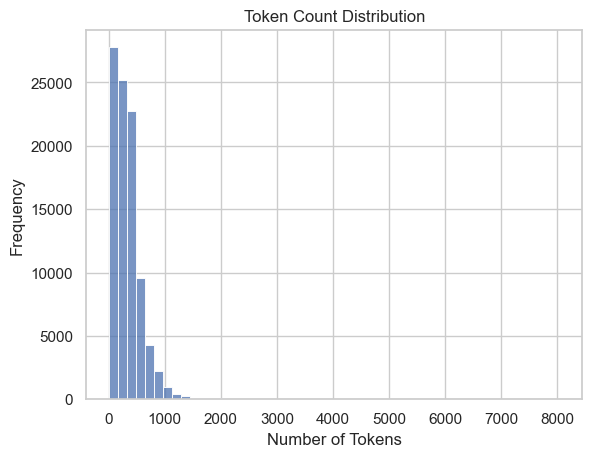

count    93784.000000
mean      1863.371481
std       1648.925255
min          4.000000
25%        721.000000
50%       1676.000000
75%       2532.000000
max      50121.000000
Name: text, dtype: float64 

count    93784.000000
mean       316.981393
std        277.288625
min          1.000000
25%        123.000000
50%        286.000000
75%        429.000000
max       8044.000000
Name: text, dtype: float64 

count    93784.000000
mean        46.285273
std         50.877998
min          0.000000
25%         17.000000
50%         40.000000
75%         62.000000
max       7295.000000
Name: punct_count, dtype: float64 

count    93784.000000
mean         4.900137
std          0.404408
min          2.000000
25%          4.660333
50%          4.888889
75%          5.111111
max         22.428571
Name: avg_word_len, dtype: float64 

count    93784.000000
mean        19.120692
std          5.976349
min          1.000000
25%         15.282609
50%         18.900000
75%         22.555556
max        

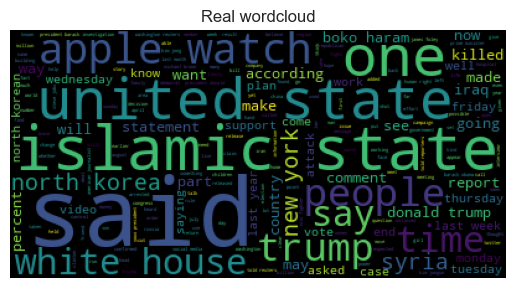

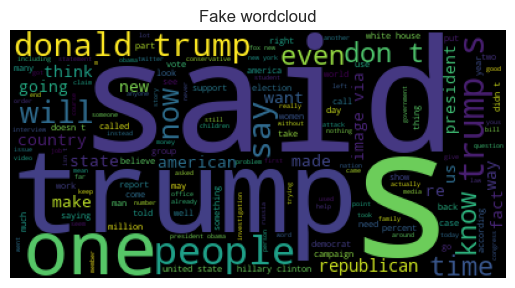


Average char reduction from raw to clean: 77.8


In [3]:
CONTRACTIONS = {
    "can't": "cannot", "won't": "will not", "i'm": "i am", "it's": "it is",
    "he's": "he is", "she's": "she is", "they're": "they are", "we're": "we are",
    "that's": "that is", "there's": "there is", "what's": "what is",
    "couldn't": "could not", "shouldn't": "should not", "wouldn't": "would not",
    "don't": "do not", "doesn't": "does not", "didn't": "did not", "isn't": "is not",
    "aren't": "are not", "wasn't": "was not", "weren't": "were not", "haven't": "have not",
    "hasn't": "has not", "hadn't": "had not", "let's": "let us", "you're": "you are"
}
SLANGS = {
    "u": "you", "ur": "your", "r": "are", "lol": "laughing out loud",
    "omg": "oh my god", "idk": "i do not know", "imo": "in my opinion",
    "btw": "by the way", "thx": "thanks", "pls": "please"
}

CONTRACTIONS_RE = re.compile(r'\b(' + '|'.join(map(re.escape, CONTRACTIONS.keys())) + r')\b')
SLANGS_RE       = re.compile(r'\b(' + '|'.join(map(re.escape, SLANGS.keys())) + r')\b')
DATE_RE   = re.compile(r'\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})\b')
NUMBER_RE = re.compile(r'\b\d+(\.\d+)?\b')

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
lemmatizer = WordNetLemmatizer()

def CleanText(text: str) -> str:
    text = text.lower()
    text = CONTRACTIONS_RE.sub(lambda m: CONTRACTIONS[m.group(0)], text)
    text = SLANGS_RE.sub(lambda m: SLANGS[m.group(0)], text)
    text = text.encode('ascii', 'ignore').decode()
    text = DATE_RE.sub('<DATE>', text)
    text = NUMBER_RE.sub('<NUM>', text)
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\W+", " ", text)
    return re.sub(r"\s+", " ", text).strip()

records = []

for fname, label in [("Fake.csv", 1), ("True.csv", 0)]:
    df = pd.read_csv(os.path.join(ISOT_DIR, fname))
    for raw in df["text"].astype(str):
        clean = CleanText(raw)
        records.append({"raw": raw, "text": clean, "Label": label})

for split in ["train.tsv", "valid.tsv", "test.tsv"]:
    df = pd.read_csv(
        os.path.join(LIAR_DIR, split), sep="\t", header=None,
        names=["ID","Label","Statement","Subject","Speaker","Job","State","Party",
               "BTrue","False","Half","Mostly","Pants","Context"]
    )
    for raw, lbl in zip(df["Statement"].astype(str), df["Label"]):
        clean = CleanText(raw)
        bin_lbl = 0 if lbl in ["true","mostly-true"] else 1
        records.append({"raw": raw, "text": clean, "Label": bin_lbl})

bodies  = pd.read_csv(os.path.join(FNC_DIR, "train_bodies.csv"))
stances = pd.read_csv(os.path.join(FNC_DIR, "train_stances.csv"))
df_fnc  = stances.merge(bodies, on="Body ID")
for head, body, stance in zip(df_fnc["Headline"].astype(str),
                              df_fnc["articleBody"].astype(str),
                              df_fnc["Stance"]):
    full_raw = f"{head} {body}"
    clean    = CleanText(full_raw)
    lbl      = 1 if stance == "disagree" else 0
    records.append({"raw": full_raw, "text": clean, "Label": lbl})

inspect_df = pd.DataFrame(records)
print("Total examples loaded:", len(inspect_df))

empty_mask = inspect_df["text"].str.split().map(len) == 0
print(f"Found {empty_mask.sum()} empty-clean examples.")
all_df = inspect_df.loc[~empty_mask].reset_index(drop=True).sample(frac=1, random_state=42)
all_df["orig_idx"] = all_df.index 
print("After dropping empties, dataset size:", len(all_df))

all_df['tokens'] = all_df['text'].str.split()
all_df['lemmas'] = all_df['tokens'].apply(lambda toks: [lemmatizer.lemmatize(t) for t in toks])

all_df['flesch_reading_ease'] = all_df['text'].apply(
    lambda txt: textstat.flesch_reading_ease(txt) if txt else np.nan
)

all_df['punct_count'] = all_df['raw'].apply(
    lambda s: sum(1 for c in s if c in string.punctuation)
)

all_df['avg_word_len'] = all_df['tokens'].apply(
    lambda toks: np.mean([len(t) for t in toks]) if toks else 0
)

def avg_sent_len(raw: str) -> float:
    sents = re.split(r'[.!?]+', raw)
    sents = [s.strip() for s in sents if s.strip()]
    if not sents:
        return 0
    return np.mean([len(s.split()) for s in sents])

all_df['avg_sent_len'] = all_df['raw'].apply(avg_sent_len)

def deduplicate_lsh(df: pd.DataFrame, text_col='text', threshold=0.99, num_perm=512) -> pd.DataFrame:
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhashes = []
    for idx, doc in df[text_col].items():
        m = MinHash(num_perm=num_perm)
        for token in doc.split():
            m.update(token.encode('utf8'))
        lsh.insert(idx, m)
        minhashes.append((idx, m))
    drop_idx = set()
    for idx, m in minhashes:
        for other in lsh.query(m):
            if other > idx and df.at[other, 'Label'] == df.at[idx, 'Label']:
                drop_idx.add(other)
    return df.drop(index=list(drop_idx)).reset_index(drop=True)

print("Before deduplication:", len(all_df))
all_df = deduplicate_lsh(all_df, text_col='text', threshold=0.99, num_perm=512)
print("After deduplication: ", len(all_df))

label_counts = all_df['Label'].value_counts().sort_index()
plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#2ca02c','#d62728'])
plt.title('Label Distribution (0=Real,1=Fake)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

token_counts = all_df['text'].str.split().map(len)
plt.figure()
sns.histplot(token_counts, bins=50, color='#4c72b0', kde=False)
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

print(all_df['text'].str.len().describe(), '\n')
print(token_counts.describe(), '\n')
print(all_df['punct_count'].describe(), '\n')
print(all_df['avg_word_len'].describe(), '\n')
print(all_df['avg_sent_len'].describe(), '\n')

print("\nFive longest cleaned examples:")
for idx in token_counts.nlargest(5).index:
    print(f"\nIndex {idx} — Tokens: {token_counts[idx]}")
    print(all_df.loc[idx, 'text'][:200] + '…')

filtered = token_counts[token_counts >= 2]
print("\nFive shortest cleaned examples:")
for idx in filtered.nsmallest(5).index:
    print(f"\nIndex {idx} — Tokens: {filtered[idx]}")
    print(all_df.loc[idx, 'text'][:200] + '…')

cnt = Counter(tok for txt in all_df['text'] for tok in txt.split())
print("\nTop 20 tokens:", cnt.most_common(20))
vocab_size = len({tok for txt in all_df['text'] for tok in txt.split()})
print("\nVocabulary size:", vocab_size)

for lbl, title in [(0, "Real"), (1, "Fake")]:
    wc = WordCloud(width=400, height=200).generate(" ".join(all_df[all_df.Label==lbl].text))
    plt.figure(); plt.imshow(wc); plt.axis("off"); plt.title(f"{title} wordcloud"); plt.show()

raw_lens   = all_df['raw'].str.len()
clean_lens = all_df['text'].str.len()
print(f"\nAverage char reduction from raw to clean: {(raw_lens - clean_lens).mean():.1f}")


--- Text Examples After Augmentation ---
ORIGINAL    : reuters yous house of representatives speaker paul ryan said on friday that the federal government would provide more funding for puerto ricos longterm rebuilding although he did not say when that funding would be approved this isnt the last aid package this is the second in more to come ryan told reporters in san juan puerto rico adding later when we get that final analysis the administration will submit yet again to congress a request for another aid package to respond to these longerterm problems on thursday the house approved billion in emergency relief for puerto rico and other areas hit by recent disasters senate approval is expected in coming weeks
AUGMENTED   : reuters yous house [MASK] representatives [MASK] paul ryan [MASK] on friday that the federal government would provide more funding for puerto [MASK] longterm rebuilding although [MASK] did not say when that funding would approved this isnt the last aid package this 

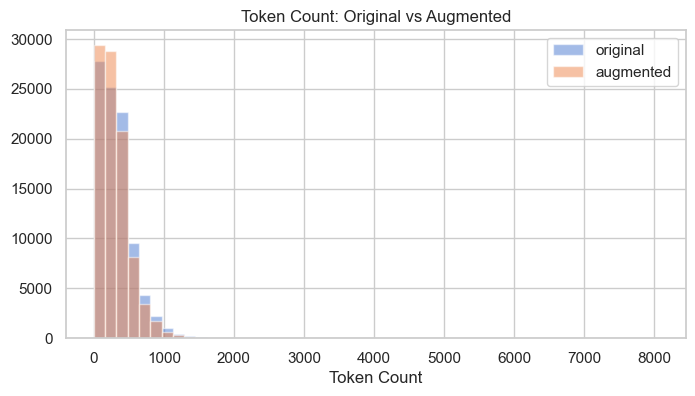

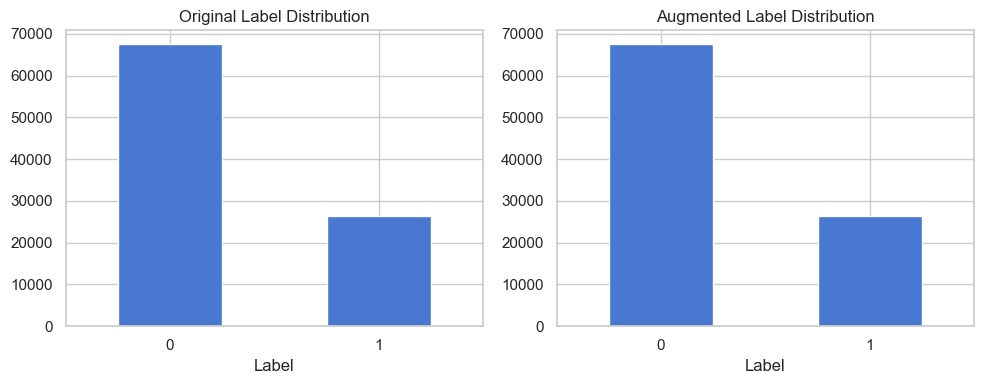

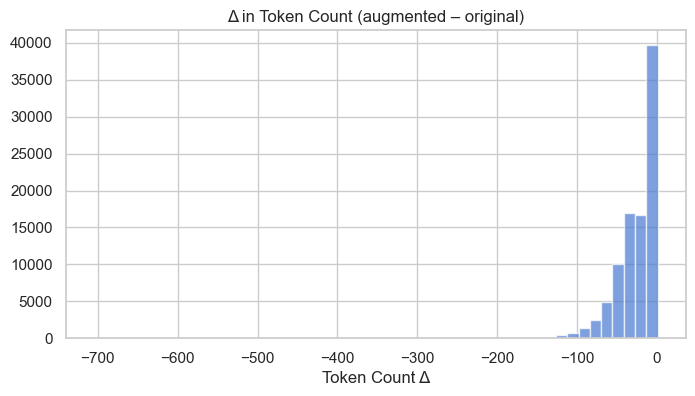

In [4]:
# Cell 3: First Augmentation (4 of 5 chosen randomly & ordered) + Diagnostics
def TokenizeSimple(text):
    return text.split()

def RandomMask(tokens, p=0.1):
    return ["[MASK]" if random.random() < p else t for t in tokens]

def SynonymReplace(tokens, swaps=1):
    r = tokens.copy()
    for _ in range(swaps):
        i = random.randrange(len(tokens))
        syns = wordnet.synsets(tokens[i])
        if syns and syns[0].lemmas():
            r[i] = syns[0].lemmas()[0].name().replace("_", "")
    return r

def RandomDeletion(tokens, p=0.1):
    if len(tokens) == 1:
        return tokens
    out = [t for t in tokens if random.random() > p]
    return out or [random.choice(tokens)]

def RandomSwap(tokens, swaps=1):
    r = tokens.copy()
    for _ in range(swaps):
        if len(r) < 2:
            break
        i, j = random.sample(range(len(r)), 2)
        r[i], r[j] = r[j], r[i]
    return r

def RandomInsert(tokens, n=1):
    r = tokens.copy()
    for _ in range(n):
        i = random.randrange(len(tokens))
        syns = wordnet.synsets(tokens[i])
        if syns and syns[0].lemmas():
            word = syns[0].lemmas()[0].name().replace("_", "")
            pos = random.randrange(len(r) + 1)
            r.insert(pos, word)
    return r

def ChainAug(tokens):
    ops = [
        lambda tks: RandomMask(tks, p=0.1),
        lambda tks: SynonymReplace(tks, swaps=1),
        lambda tks: RandomSwap(tks, swaps=1),
        lambda tks: RandomDeletion(tks, p=0.1),
        lambda tks: RandomInsert(tks, n=1)
    ]
    selected = random.sample(ops, 4)
    random.shuffle(selected)
    t = tokens
    for op in selected:
        t = op(t)
    return t

aug_texts, aug_labels = [], []
for text, label in zip(all_df.text, all_df.Label):
    toks = TokenizeSimple(text)
    chained = ChainAug(toks)
    aug_texts.append(" ".join(chained))
    aug_labels.append(label)

dfAug1 = pd.DataFrame({"text": aug_texts, "Label": aug_labels})

print("\n--- Text Examples After Augmentation ---")
for idx in np.random.choice(len(all_df), 5, replace=False):
    print(f"ORIGINAL    : {all_df.text.iloc[idx]}" )
    print(f"AUGMENTED   : {dfAug1.text.iloc[idx]}\n")

orig_counts = all_df.text.str.split().map(len)
chain_counts = dfAug1.text.str.split().map(len)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(orig_counts, bins=50, alpha=0.5, label="original")
ax.hist(chain_counts, bins=50, alpha=0.5, label="augmented")
ax.set_title("Token Count: Original vs Augmented")
ax.set_xlabel("Token Count")
ax.legend()
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,4))
all_df.Label.value_counts().sort_index().plot.bar(
    ax=axes[0], title="Original Label Distribution", rot=0
)
dfAug1.Label.value_counts().sort_index().plot.bar(
    ax=axes[1], title="Augmented Label Distribution", rot=0
)
plt.tight_layout()
plt.show()

delta = chain_counts.values - orig_counts.values
plt.figure(figsize=(8,4))
plt.hist(delta, bins=50, alpha=0.7)
plt.title("Δ in Token Count (augmented – original)")
plt.xlabel("Token Count Δ")
plt.show()

Training examples:   151727
Validation examples: 16857
Test examples:       18732

--- Sample training instances ---
 orig_idx                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

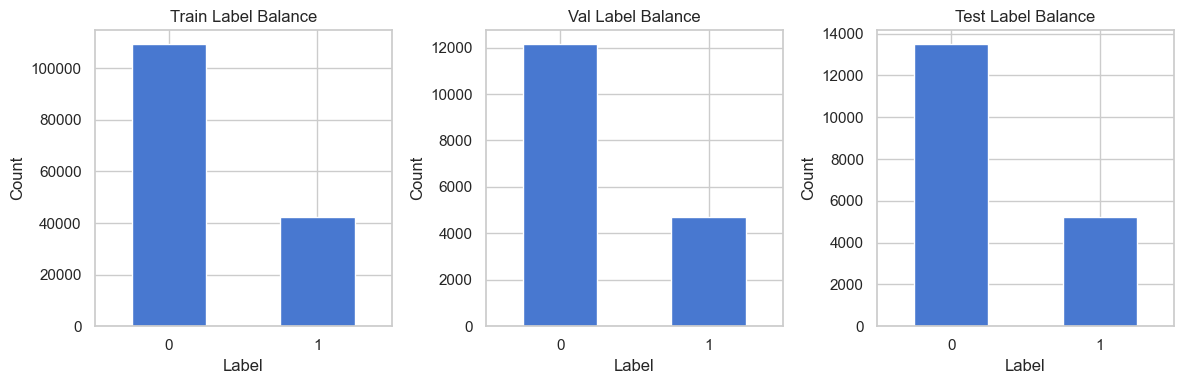

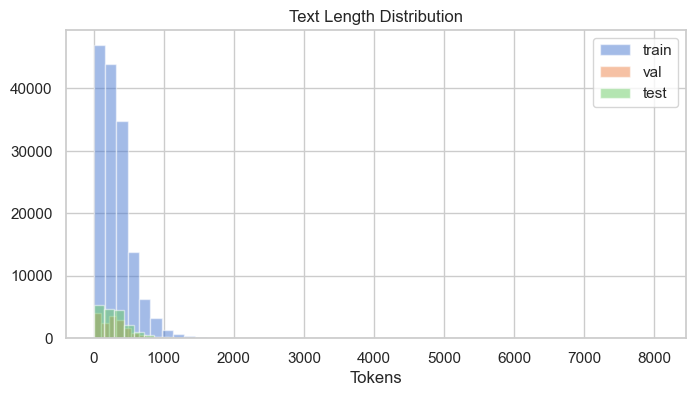

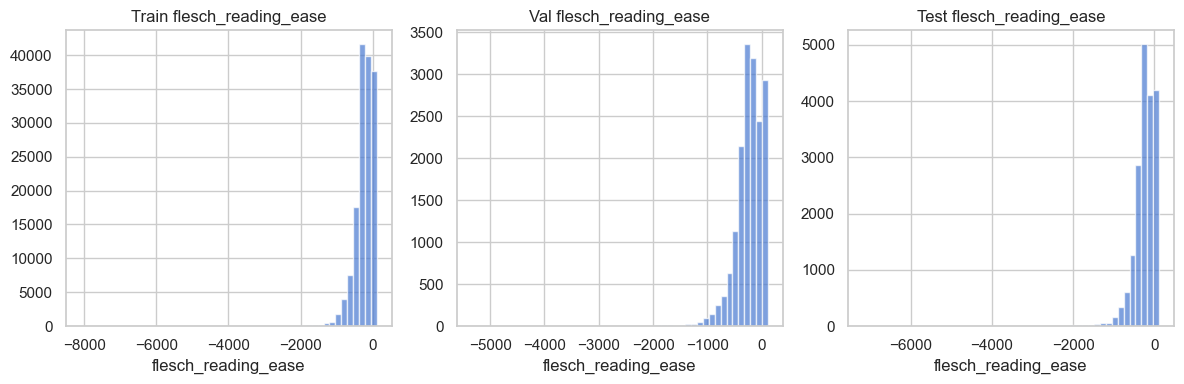

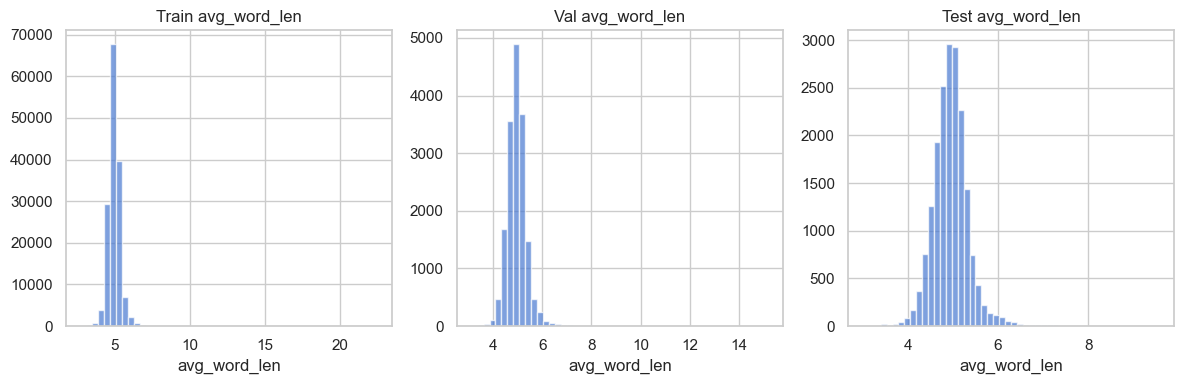

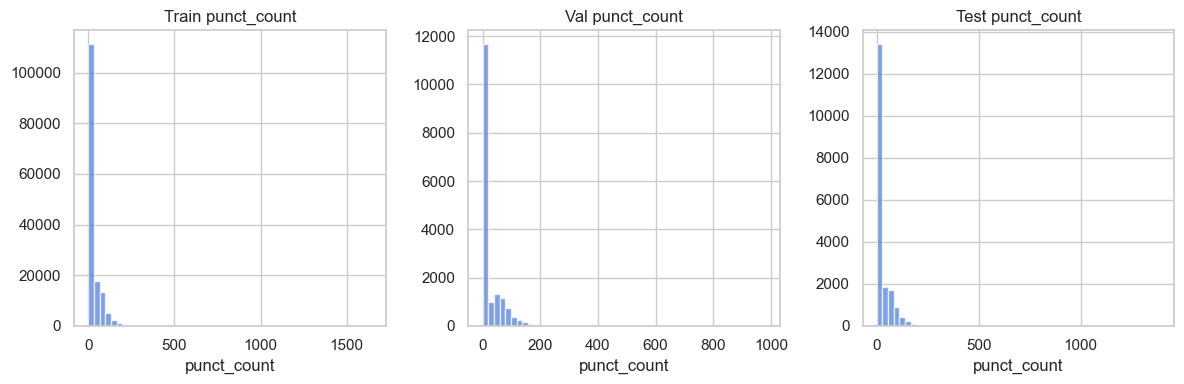

In [5]:
# Cell 5: Combine Originals + Aug1 → Split (no back-translation, leak-proof, reproducible, stratified via sklearn, tokenized cache)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

orig_df    = all_df[['text','Label']].copy().reset_index().rename(columns={'index':'orig_idx'})
dfAug1_idx = dfAug1.reset_index().rename(columns={'index':'orig_idx'})

orig_df['token_count'] = orig_df.text.str.split().map(len)
min_len = 5
orig_df = orig_df[orig_df.token_count >= min_len].reset_index(drop=True)

length_bins   = [0,50,200,500,1000,orig_df.token_count.max()]
length_labels = ['0-50','51-200','201-500','501-1000','1000+']
orig_df['length_bucket'] = pd.cut(orig_df.token_count, bins=length_bins, labels=length_labels, include_lowest=True)
orig_df['stratify_grp']  = orig_df.Label.astype(str) + '_' + orig_df.length_bucket.astype(str)

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
for trainval_idx, test_idx in sss1.split(orig_df, orig_df['stratify_grp']):
    orig_trainval = orig_df.iloc[trainval_idx]
    orig_test     = orig_df.iloc[test_idx]
test_ids = set(orig_test.orig_idx)

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
for train_idx, val_idx in sss2.split(orig_trainval, orig_trainval['stratify_grp']):
    orig_train = orig_trainval.iloc[train_idx]
    orig_val   = orig_trainval.iloc[val_idx]
train_ids = set(orig_train.orig_idx)
val_ids   = set(orig_val.orig_idx)

combined = pd.concat([orig_df.drop(columns=['stratify_grp']), dfAug1_idx], ignore_index=True)
combined = combined.sample(frac=1, random_state=seed).reset_index(drop=True)
combined['token_count']   = combined.text.str.split().map(len)
combined = combined[combined.token_count >= min_len].reset_index(drop=True)
combined['length_bucket'] = pd.cut(combined.token_count, bins=length_bins, labels=length_labels, include_lowest=True)

train_df = combined[combined.orig_idx.isin(train_ids)].reset_index(drop=True)
val_df   = combined[combined.orig_idx.isin(val_ids)].reset_index(drop=True)
test_df  = combined[combined.orig_idx.isin(test_ids)].reset_index(drop=True)

classes         = np.unique(train_df.Label)
weights         = compute_class_weight('balanced', classes=classes, y=train_df.Label)
class_weights_t = torch.tensor(weights, dtype=torch.float)

datasets = DatasetDict({
    'train':      Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(val_df),
    'test':       Dataset.from_pandas(test_df)
})

tokenizer      = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenized_path = TOKEN_DIR

if os.path.isdir(tokenized_path):
    datasets = load_from_disk(tokenized_path)
else:
    def tokenize_fn(batch):
        return tokenizer(batch['text'], padding=True, truncation=True, max_length=tokenizer.model_max_length)
    datasets = datasets.map(tokenize_fn, batched=True, remove_columns=['text'], load_from_cache_file=True)
    datasets.save_to_disk(tokenized_path)

print(f"Training examples:   {len(train_df)}")
print(f"Validation examples: {len(val_df)}")
print(f"Test examples:       {len(test_df)}\n")

print("--- Sample training instances ---")
print(train_df.sample(3, random_state=seed).to_string(index=False), "\n")
print("--- Sample validation instances ---")
print(val_df.sample(3, random_state=seed).to_string(index=False), "\n")
print("--- Sample test instances ---")
print(test_df.sample(3, random_state=seed).to_string(index=False), "\n")

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, (df, split) in zip(axes, [(train_df,'train'), (val_df,'val'), (test_df,'test')]):
    df.Label.value_counts().sort_index().plot.bar(ax=ax, rot=0)
    ax.set_title(f"{split.title()} Label Balance")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
for df, label in [(train_df,'train'), (val_df,'val'), (test_df,'test')]:
    lengths = df.text.str.split().map(len)
    ax.hist(lengths, bins=50, alpha=0.5, label=label)
ax.set_title("Text Length Distribution"); ax.set_xlabel("Tokens"); ax.legend(); plt.show()

metrics = {
    'flesch_reading_ease': lambda txt: textstat.flesch_reading_ease(txt),
    'avg_word_len':        lambda txt: np.mean([len(w) for w in txt.split()]) if txt.split() else 0,
    'punct_count':         lambda txt: sum(1 for c in txt if c in string.punctuation)
}
for name, func in metrics.items():
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    for ax, (df, split) in zip(axes, [(train_df,'train'),(val_df,'val'),(test_df,'test')]):
        vals = df.text.map(func)
        ax.hist(vals, bins=50, alpha=0.7)
        ax.set_title(f"{split.title()} {name}")
        ax.set_xlabel(name)
    plt.tight_layout(); plt.show()


In [7]:
# Cell 6: Domain-Adaptive MLM Pre-training (map-caching + validation + diagnostics)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_mlm(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

if TOKENIZED_CACHE.exists():
    mlm_ds = load_from_disk(str(TOKENIZED_CACHE))
else:
    ds_train = Dataset.from_pandas(train_df)
    ds_val   = Dataset.from_pandas(val_df)
    tok_train = ds_train.map(tokenize_mlm, batched=True, remove_columns=["text", "Label"])
    tok_val   = ds_val.map(  tokenize_mlm, batched=True, remove_columns=["text", "Label"])
    mlm_ds = DatasetDict({"train": tok_train, "validation": tok_val})
    TOKENIZED_CACHE.parent.mkdir(parents=True, exist_ok=True)
    mlm_ds.save_to_disk(str(TOKENIZED_CACHE))

mlm_model_exists = (Path(MLM_OUTPUT_DIR) / "config.json").exists()

collator = DataCollatorForLanguageModeling(tokenizer, mlm_probability=0.15)

ta_kwargs = dict(
    output_dir                  = MLM_OUTPUT_DIR,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 1,
    optim                       = "adamw_torch",
    adam_beta1                  = 0.9,
    adam_beta2                  = 0.999,
    adam_epsilon                = 1e-8,
    group_by_length             = True,
    dataloader_num_workers      = 4,
    dataloader_pin_memory       = True,
    fp16                        = True,
    num_train_epochs            = 7,
    logging_steps               = 500,
    evaluation_strategy         = "epoch",
    save_strategy               = "no",
    disable_tqdm                = False,
    report_to                   = [],
)
# filter out any args not supported in this version of Transformers
sig_args  = inspect.signature(TrainingArguments.__init__).parameters
ta_kwargs = {k: v for k, v in ta_kwargs.items() if k in sig_args}
mlm_args  = TrainingArguments(**ta_kwargs)

if mlm_model_exists:
    print(f"▶︎ Found existing MLM model in {MLM_OUTPUT_DIR}, loading…")
    mlm_model = DistilBertForMaskedLM.from_pretrained(MLM_OUTPUT_DIR)
else:
    print("▶︎ No existing MLM model found, running pre-training…")
    mlm_model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")
    trainer   = Trainer(
        model         = mlm_model,
        args          = mlm_args,
        train_dataset = mlm_ds["train"],
        eval_dataset  = mlm_ds["validation"],
        data_collator = collator,
    )
    trainer.train()
    mlm_model.save_pretrained(MLM_OUTPUT_DIR)
    print("▶︎ MLM pre-training complete.")

# (re-)instantiate trainer for evaluation
trainer = Trainer(
    model         = mlm_model,
    args          = mlm_args,
    train_dataset = mlm_ds["train"],
    eval_dataset  = mlm_ds["validation"],
    data_collator = collator,
)

train_metrics = trainer.evaluate(mlm_ds["train"])
val_metrics   = trainer.evaluate(mlm_ds["validation"])
print(f"TRAIN ▶ loss={train_metrics['eval_loss']:.4f}  ppl={math.exp(train_metrics['eval_loss']):.2f}")
print(f" VAL  ▶ loss={val_metrics  ['eval_loss']:.4f}  ppl={math.exp(val_metrics  ['eval_loss']):.2f}")

fill = pipeline(
    "fill-mask",
    model     = mlm_model,
    tokenizer = tokenizer,
    device    = 0 if torch.cuda.is_available() else -1,
)

print("\nSample predictions:")
for txt in all_df.text.sample(3, random_state=42):
    toks = txt.split()
    if len(toks) > 3:
        toks[1] = tokenizer.mask_token
        masked  = " ".join(toks[:20])
        print("INPUT:", masked)
        for p in fill(masked)[:3]:
            print(" →", p["token_str"], f"({p['score']:.2f})")
        print()

▶︎ Found existing MLM model in X:\Projects\Personal\Fake News Detector\outputs\mlm output, loading…


Device set to use cuda:0


TRAIN ▶ loss=1.3313  ppl=3.79
 VAL  ▶ loss=1.5019  ppl=4.49

Sample predictions:
INPUT: nonpartisan [MASK] analysts say obamacare will cost our economy up to million jobs
 → political (0.49)
 → government (0.11)
 → fiscal (0.08)

INPUT: christian [MASK] will not play steve jobs as a feelgood video of a generous homeless man continues to touch and
 → bal (0.29)
 → who (0.17)
 → actor (0.09)

INPUT: a [MASK] of people thought banksy got arrested but it was a hoax fear not the street artist is still
 → lot (0.68)
 → bunch (0.21)
 → ton (0.05)



In [10]:
# Cell 7: Classification Fine-tuning (LoRA + Adversarial Training)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_cls(batch):
    tok = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    tok["labels"] = batch["Label"]
    return tok

if CLS_CACHE.exists():
    cls_ds = load_from_disk(str(CLS_CACHE))
else:
    raw_train = Dataset.from_pandas(train_df)
    raw_val   = Dataset.from_pandas(val_df)

    tok_train = raw_train.map(
        tokenize_cls,
        batched=True,
        remove_columns=["text", "Label"]
    )
    tok_val   = raw_val.map(
        tokenize_cls,
        batched=True,
        remove_columns=["text", "Label"]
    )

    cls_ds = DatasetDict({"train": tok_train, "validation": tok_val})
    CLS_CACHE.parent.mkdir(parents=True, exist_ok=True)
    cls_ds.save_to_disk(str(CLS_CACHE))

train_ds, val_ds = cls_ds["train"], cls_ds["validation"]

cls_model = DistilBertForSequenceClassification.from_pretrained(
    MLM_OUTPUT_DIR,
    num_labels=2,
    ignore_mismatched_sizes=True
)

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_lin", "v_lin"]
)
cls_model = get_peft_model(cls_model, lora_config)

data_coll = DataCollatorWithPadding(tokenizer)

class AdvTrainer(Trainer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fn = CrossEntropyLoss(weight=class_weights_t.to(logits.device))
        loss    = loss_fn(logits.view(-1, 2), labels.view(-1))

        emb      = model.get_input_embeddings()(inputs["input_ids"])
        emb.requires_grad_(True)
        adv_out  = model(inputs_embeds=emb, labels=labels)
        total    = (loss + adv_out.loss) / 2

        return (total, outputs) if return_outputs else total

train_args = TrainingArguments(
    output_dir                 = CHECKPOINT_DIR,
    eval_strategy              = "epoch",
    save_strategy              = "epoch",
    learning_rate              = 2e-5,
    warmup_steps               = 500,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size = 16,
    num_train_epochs           = 8,
    weight_decay               = 0.01,
    load_best_model_at_end     = True,
    metric_for_best_model      = "f1",
    fp16                       = True,
    save_total_limit           = 3,
    logging_steps              = 500,
    disable_tqdm               = False,
    report_to                  = []
)

adv_trainer = AdvTrainer(
    model           = cls_model,
    args            = train_args,
    train_dataset   = train_ds,
    eval_dataset    = val_ds,
    tokenizer       = tokenizer,
    data_collator   = data_coll,
    compute_metrics = lambda p: {
        "accuracy": (np.argmax(p.predictions,1) == p.label_ids).mean(),
        "f1": evaluate.load("f1").compute(
            predictions=np.argmax(p.predictions,1),
            references=p.label_ids,
            average="binary"
        )["f1"]
    },
    epsilon=1e-5
)

adv_trainer.train()
adv_trainer.save_model(f"{CHECKPOINT_DIR}/BestModel")

# evaluate
train_metrics = adv_trainer.evaluate(train_ds, metric_key_prefix="train")
val_metrics   = adv_trainer.evaluate(val_ds,   metric_key_prefix="val")

raw_test     = Dataset.from_pandas(test_df)
test_ds      = raw_test.map(tokenize_cls, batched=True, remove_columns=["text", "Label"])
test_metrics = adv_trainer.evaluate(test_ds, metric_key_prefix="test")

print(f"TRAIN ▶ loss={train_metrics['train_loss']:.4f} "
      f"Acc={train_metrics['train_accuracy']:.4f} "
      f"F1={train_metrics['train_f1']:.4f}")
print(f" VAL  ▶ loss={val_metrics  ['val_loss']:.4f} "
      f"Acc={val_metrics  ['val_accuracy']:.4f} "
      f"F1={val_metrics  ['val_f1']:.4f}")
print(f" TEST ▶ loss={test_metrics['test_loss']:.4f} "
      f"Acc={test_metrics['test_accuracy']:.4f} "
      f"F1={test_metrics['test_f1']:.4f}")

pred_out   = adv_trainer.predict(test_ds)
y_pred     = np.argmax(pred_out.predictions, axis=1)
y_true     = pred_out.label_ids
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"Confusion Matrix: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_true, pred_out.predictions[:,1]):.4f}")
print(classification_report(y_true, y_pred, digits=4))

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.126500,0.117114,0.944125,0.907338
2,0.113400,0.113082,0.945192,0.909109
3,0.116200,0.112231,0.945311,0.909127
4,0.110900,0.111023,0.945430,0.909288
5,0.117300,0.111142,0.945845,0.909934
6,0.103800,0.109278,0.946082,0.910487
7,0.100400,0.108870,0.946142,0.910770
8,0.104200,0.109663,0.945964,0.910308


Map:   0%|          | 0/18732 [00:00<?, ? examples/s]

TRAIN ▶ loss=0.1011 Acc=0.9465 F1=0.9110
 VAL  ▶ loss=0.1089 Acc=0.9461 F1=0.9108
 TEST ▶ loss=0.1171 Acc=0.9439 F1=0.9066
Confusion Matrix: TP=5093, FP=895, FN=155, TN=12589
Precision: 0.8505
Recall:    0.9705
ROC-AUC:   0.9894
              precision    recall  f1-score   support

           0     0.9878    0.9336    0.9600     13484
           1     0.8505    0.9705    0.9066      5248

    accuracy                         0.9439     18732
   macro avg     0.9192    0.9520    0.9333     18732
weighted avg     0.9494    0.9439    0.9450     18732

